# Intro. to Scripting - Python Assignment
---

#### Student: Osama Shamout | 201906271

## Assignment Prompt

## <font color=green size=5px>**Part 1**</font>
<font size=3px>The first part of the assignment consists of retrieving from the Protein Data bank one or more PDB files using Python libraries for web scrapping (*Selenium, BeautifulSoup, ...*)
<br>Every record/entry in this database is represented by a 4-character unique identifier. A PDB file has a ".pdb" extension.

An example of a PDB file URL is presented below (3GWD being the identifier that changes between entries): <br>
http://files.rcsb.org/view/3GWD.pdb 

 
<br>The program will start by prompting the user to enter a list of identifier(s) (separated by spaces) to retrieve from the database.
    
This part of the code must manage the below points:
* User has entered valid ID(s) (4 alphanumeric characters); return an error message if it is not the case. 
* The script must not download again a file that was previously retrieved and stored locally on the disk. 
* Some of the identifiers do not exist in the database; return a message informing the user which identifier(s) was/were not found.
* We are only interested in files containing protein structures determined by X-ray diffraction. These files can be easily identified by looking at the line starting with `EXPDTA` and REMARK line with `PROTEIN ATOMS` greater than 0. The Other files should be discarded and deleted. 
</font>

### Import Libraries
---


In [61]:
## urllib library needed to download html documents for later usage.
import urllib

## BeautifulSoup library imported to enable web scraping of websites. 
## Read more about library usage and documentation @ https://www.crummy.com/software/BeautifulSoup/bs4/doc/). Version upon creating document: 4.8.1.
## Note some libraries might not be automatically installed. Check IDE Envrionment and libraries documentation to understand how to run the library.
from bs4 import BeautifulSoup  

## Add system libraries to assist in file creation and relevant operating system commands.
import os

## Import regex
import re

## BeautifulSoup is used to webscrape pdb
from bs4 import BeautifulSoup

## Pathlib & Glob to manipulate files
from pathlib import Path
import glob

## Pandas for dataframe manipulation
import pandas as pd

## Numpy for list math manipulation
import numpy as np

## Plotly for plotting
import plotly.graph_objects as go
from plotly.subplots import make_subplots

---

### Load Read & Download Methods
---

In [26]:
def check_file_exists(user_input):
    """
    Check if file exists
    

    Parameters
    ----------
    user_input: is the file path by user
    
    Returns
    -------
    True if file exists, false otherwise
    """
    #Create list of files donwloaded
    files_downloaded = [f for f in os.listdir('.') if os.path.isfile(f)]
    
    print("\nChecking if file has been downloaded...")
    for f in files_downloaded:
        ## print(f)
        if (f == user_input):
            #print("File exists locally.")
            return True
    print("File does not exist locally.\n")
    return False

def generate_pdb (query=''):
    """
    Function takes in the user's inputted query 
    and generates PDB file as a .txt
    

    Parameters
    ----------
    query : STRING
        THE USER'S INPUTTED ID. The default is ''.

    Returns
    -------
    page : 
        DESCRIPTION.

    """
           
    ## Build URL of PDB File
    url = 'http://files.rcsb.org/view/' + query + ".pdb"  
    ## Get Parameters of Query
    params = {
    'from':"PDB_ID",
    'to':'ACC',
    'format':'txt',
    'query':query
    }
    ## Parse into Readable Format
    data = urllib.parse.urlencode(params)
    data = data.encode('ascii')
    ## Get from URL
    request = urllib.request.Request(url, data)
    try:
        print("\nChecking if file in the online database...")
        with urllib.request.urlopen(request) as response:
            ## Read Lines
            res = response.read()
            page=BeautifulSoup(res, features = "lxml").get_text()
            
            ## Check if pdb has XRAY
            xray_pdb = re.search("EXPDTA\s+X-RAY\s+DIFFRACTION", page)
            if not xray_pdb:
                return (None, 1)
            
            ## Check if protein atoms > 0
            atoms = re.search("REMARK\s+\d+\s+PROTEIN\s+ATOMS\s+:\s+(\d+)", page)
            num_atoms = int(atoms.group(1))
            if num_atoms == 0:
                return (None, 2)
            
            ## Split Lines into a List
            page=page.splitlines()
            
    except Exception:
        ## print("File not found in the online database.")
        return (None, 3)
    
    
    ## Save in the form of `query_id`.txt
    file_name = query + ".txt"
    with open(file_name, 'w') as f:
        for line in page:
            f.write("%s\n" % line)
    print("File found in online database.")
    return (page, 0)
      
def download_pdb(query, ignore_invalid = "n"):
    """
    Function that gets user input for the PDB ID and
    validates by alphanumeric of size 4
    &&
    Then downloads the pdb if it exists 

    
    Loops user until a correct input is given.

    Returns
    -------
    query : STRING
        THE USER'S INPUTTED ID.

    """
    pdb_create = False
    error = False
    invalid_input = False
    not_available = False
    
    if ignore_invalid=="y":
        ignore_invalid = True
    else:
        ignore_invalid = False
    

    while not pdb_create:
        ## Print message if an error is obtained
        if error:
            print(f"{query} is already downloaded.")
            error = False
            ## Get Input
            if not ignore_invalid:
                query = input("Enter PDB ID: ")
            else:
                return
            
        ## Print message if the user entered an invalid Query
        if invalid_input:
            print(f"{query} is not Valid: Must be 4 Alphanumeric Characters.")
            invalid_input = False
            ## Get Input
            if not ignore_invalid:
                query = input("Enter PDB ID: ")
            else:
                return
        ## Print message if the Query is available in the pdb
        if not_available:
            print(f"{query} is not Available in Protein Bank Database.")
            not_available = False
            ## Get Input
            if not ignore_invalid:
                query = input("Enter PDB ID: ")
            else:
                return
        #> For Debugging
        ## print("\nChecking if alhphanumeric condition satisfied...")
        
        ## Restrict input to be alphanumeric of 4 characters.
        expression = re.search("^([A-Za-z0-9]){4}$", query)
        
        ## If Query has invalid format, re-enter loop
        if not expression:
            #> print("Invalid ID. Enter 4 alphanumeric valid ID.")
            invalid_input = True
            ## Continue to restart loop
            continue
            
        ## Query has valid format.
        ## print("Valid Input")
        file_name = query + ".txt"
        ## Check if File exists
        if check_file_exists(file_name):
            pdb_create = False
            error = True
            continue
        ## File does not exist
        else:
            pdb_create = True 
          
        ## Generate the pdb 
        pdb, return_value = generate_pdb(query)
        if return_value == 1:
            print(f"{query} does not contain X-Ray Diffraction and was not downloaded.")
            return
        
        if return_value == 2:
            print(f"{query} has 0 atoms and was not downloaded.")
            return
        
        ## If no pdb is returned => pdb query is not in database
        if return_value == 3:
            pdb_create = False
            not_available = True
            continue
        else:
            print(f"{query}.txt downloaded.")

def read_input():
    """
    Reads the input from the user
    1- Asks user for the number of pdb files to download
    2- Downloads the pdb files.

    Returns
    -------
    None.

    """
    num_files = int(input("Enter the number of pdb files you would like to download: "))
    if num_files == 0:
        print("No files added.\n-------------")
        return
    
    ## Build the list of pdb ids
    pdb_ids = []
    for i in range(num_files):
        pdb_id = input(f"Enter pdb #{i+1}: ")
        pdb_ids.append(pdb_id)
    
    ignore_invalid = input("Do you wish to ignore Invalid IDs (y or n): ")
    print("------------------")
    for pdb_id in pdb_ids:
        print(f"Trying to download {pdb_id}...")
        download_pdb(pdb_id, ignore_invalid)
        print("------------------")

#### Test Code

In [27]:
## Test Reading User Input to Download PDB Files
read_input()

Enter the number of pdb files you would like to download:  1
Enter pdb #1:  3eve
Do you wish to ignore Invalid IDs (y or n):  n


------------------
Trying to download 3eve...

Checking if file has been downloaded...
3eve is already downloaded.


Enter PDB ID:  asdg



Checking if file has been downloaded...
File does not exist locally.


Checking if file in the online database...
asdg is not Available in Protein Bank Database.


Enter PDB ID:  12dasj


12dasj is not Valid: Must be 4 Alphanumeric Characters.


Enter PDB ID:  1eve



Checking if file has been downloaded...
File does not exist locally.


Checking if file in the online database...
File found in online database.
1eve.txt downloaded.
------------------


---

## Assignment Prompt
## <font color=green size=5px>**Part 2**</font>
<font size=3px> The second part consists of computing some statistics about the content in amino acids of the protein files previously retrieved.<br>
    
    
Note that there are many introductory lines and remarks at the top of the PDB file, as well as few lines at the end, which do not contain the amino acid information. The lines of interests are the one starting with the word `ATOM` and containing `CA` in the Atom name field.<br>
    
    
<br>20 different standard amino acids exist in proteins (A, C, D, E, F, G, H, I, K, L, M, N, P, Q, R, S, T, V, W, Y), and these amino acids are divided into 4 categories according to their properties:
-	Positively charged: R, H, K
-	Negatively charged: D, E
-	Polar: N, C, Q, S, T, Y
-	Non-polar : A, I, L, M, F, P, W, V, G

    
In the PDB file, amino acids are represented by their 3-letter abbreviation. Check the picture below for the various correspondences.
    
<img src="https://useruploads.socratic.org/lTF7dKeTlW0memd6bf35_aminoacidcode2.png" alt="Amino Acids" style="width:500px">
    
For a description regarding the PDB file format check this link below:
http://www.wwpdb.org/documentation/file-format-content/format33/sect9.html#ATOM

</font>
<font size=3px>

The goal of this assignment is to ONLY use Python programming language to write a script that starts by displaying the following menu on the screen:<br>
1) ALL<br>
2) Per category<br>
3) Within category<br>
4) Specific AA<br>
    
### The first task:
    
> 1) If the user selects this option, the script will calculate the **combined** frequency and percentage of each of the 20 amino acid in the different PDB files and print the results in a table sorted in <b>reverse numerical order</b> according to the percentage values. The table must contain 3 columns that correspond to the amino acid one-letter, its frequency and its percentage.

### Startegy:
1. Read the PDB Files 
2. Extract the aminoacids from each pdb file
    a. count frequency
    b. get percentage
3. Build DataFrame and return it

       

In [29]:
def get_data():
    """
    This method will read the pdb files
        and add the aminacids information to dataframe    

    Returns
    -------
    Dataframe of (aminaocid_cod, frequency, percentage)
    """
    ## --------
    ## Strategy:
    ## --------
    ## Data:
    ##    dataframe of (residue, frequency)
    ## Plan:
    ## 1. Go through each file
    ## 2. Go through each line
    ## 3. Regex for Atoms Signature
    ## 4. Add Data about new Residue
    
    columns = ["aminoacid", "frequency"]
    df = pd.DataFrame(columns = columns)
    
    dictionary_of_aa = {}
    
    for file in glob.glob("*.txt"):
        txt = Path(file).read_text()
        regex = re.compile('ATOM\s+\d+\s+CA\s+(\w{3})\s+')
        result = regex.findall(txt)
        for amino_acid in result:
            ## check if inside dictionary
            if amino_acid in dictionary_of_aa:
                dictionary_of_aa[amino_acid] = dictionary_of_aa[amino_acid] + 1
            else:
                dictionary_of_aa[amino_acid] = 1
    return dictionary_of_aa
        

def all_combined(amino_acids_frq):
    """
    This function calculates the frequency and percentages of each aminoacid
    
    Returns
    -------
    Dataframe (amino acid, frequency, percentage)
    
    """
    three_to_one = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
                    'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
                    'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
                    'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
    ## Calculate Total Frequency
    total_frequency = 0
    for key,value in amino_acids_frq.items():
        total_frequency += value
    
    ## Calculate Each Percentage
    percentages = []
    for key,value in amino_acids_frq.items():
        percentages.append(round(value/total_frequency*100, ndigits = 2))
    
    aa_list = []
    frq_list = []
    for key,value in amino_acids_frq.items():
        ## Change from 3 letters to one letter
        key = three_to_one[key]
        ## Add Aminoacids
        aa_list.append(key)
        ## Add Frequencies
        frq_list.append(value)
    
    ## Create Dataframe
    df = pd.DataFrame(columns = ["amino acid", "frequency", "percentage"])
    df["amino acid"] = aa_list
    df["frequency"]  = frq_list
    df["percentage"] = percentages
    
    ## Sort by percentage and return
    df = df.sort_values(by="percentage", ascending = False, ignore_index = True)
    return(df)

#### Test Code

In [30]:
## Test get_data() and all_combined()
amino_acids_data = get_data()
df               = all_combined(amino_acids_data)
print(df)

   amino acid  frequency  percentage
0           G        126        8.57
1           L        126        8.57
2           V        117        7.95
3           E        107        7.27
4           A         96        6.53
5           S         90        6.12
6           T         89        6.05
7           R         87        5.91
8           D         80        5.44
9           F         76        5.17
10          P         75        5.10
11          N         70        4.76
12          K         69        4.69
13          I         65        4.42
14          Y         50        3.40
15          Q         38        2.58
16          W         35        2.38
17          H         35        2.38
18          M         24        1.63
19          C         16        1.09


<font size=3px>
    
### Second Task:

> 2) If the user selects this option, the script will do the same as in (1), but the displayed results will be per amino acids category. The table will contain only 4 rows, each corresponding to an amino acid category.

In [31]:
def by_category(amino_acids_frq):
    """
    This function calculates the frequency and percentages of each aminoacid by category
    
    Returns
    -------
    Dataframe (category, frequency, percentage)
    """
    categories = {'CYS': 'Polar', 'ASP': 'Negatively Charged', 'SER': 'Polar',
                 'GLN': 'Polar', 'LYS': 'Positively Charged',
                 'ILE': 'Non-Polar', 'PRO': 'Non-Polar', 'THR': 'Polar',
                 'PHE': 'Non-Polar', 'ASN': 'Polar', 'GLY': 'Non-Polar',
                 'HIS': 'Positively Charged', 'LEU': 'Non-Polar',
                 'ARG': 'Positively Charged', 'TRP': 'Non-Polar', 
                 'ALA': 'Non-Polar', 'VAL':'Non-Polar', 'GLU': 'Negatively Charged',
                 'TYR': 'Polar', 'MET': 'Non-Polar'}
    
    ## Calculate Total Frequency
    cat_frequencies = {
            'Polar'              : 0,
            'Non-Polar'          : 0,
            'Positively Charged' : 0,
            'Negatively Charged' : 0}
    
    total_frequency = 0
    for key,value in amino_acids_frq.items():
        total_frequency += value
    
        cat_key = categories[key]
        cat_frequencies[cat_key] = cat_frequencies[cat_key]+value
    
    ## Calculate Each Percentage
    percentages = []
    for key,value in cat_frequencies.items():
        percentages.append(round(value/total_frequency*100, ndigits = 2))
    
    cat_list = []
    frq_list = []
    for key,value in cat_frequencies.items():
        ## Add Aminoacids
        cat_list.append(key)
        ## Add Frequencies
        frq_list.append(value)
    
    ## Create Dataframe
    df = pd.DataFrame(columns = ["category", "frequency", "percentage"])
    df["category"] = cat_list
    df["frequency"]  = frq_list
    df["percentage"] = percentages
    
    ## Sort by percentage and return
    df = df.sort_values(by="percentage", ascending = False, ignore_index = True)
    return(df)

#### Test Code:

In [32]:
## Test by_category()
amino_acids_data = get_data()
df               = by_category(amino_acids_data)
print(df)

             category  frequency  percentage
0           Non-Polar        740       50.31
1               Polar        353       24.00
2  Positively Charged        191       12.98
3  Negatively Charged        187       12.71


<font size=3px>
    
### Third Task:
    
> 3) If the user selects this option, he/she will be prompted to choose one category from the four, and the script will display the frequency and percentage of each amino acid belonging to this category. In this case, the percentage of the amino acid is computed by dividing its frequency over the total number of amino acids belonging to the same category.

In [33]:
def all_in_category(amino_acids_frq, category):    
    categories = {'CYS': 'Polar', 'ASP': 'Negatively Charged', 'SER': 'Polar',
                 'GLN': 'Polar', 'LYS': 'Positively Charged',
                 'ILE': 'Non-Polar', 'PRO': 'Non-Polar', 'THR': 'Polar',
                 'PHE': 'Non-Polar', 'ASN': 'Polar', 'GLY': 'Non-Polar',
                 'HIS': 'Positively Charged', 'LEU': 'Non-Polar',
                 'ARG': 'Positively Charged', 'TRP': 'Non-Polar', 
                 'ALA': 'Non-Polar', 'VAL':'Non-Polar', 'GLU': 'Negatively Charged',
                 'TYR': 'Polar', 'MET': 'Non-Polar'}
    
    ## Get Category Argument
    category_names = ["Non-Polar", "Polar", "Negatively Charged", "Positively Charged"]
    category_name = category_names[category-1]
    three_to_one = {'CYS': 'C', 'ASP': 'D', 'SER': 'S', 'GLN': 'Q', 'LYS': 'K',
                    'ILE': 'I', 'PRO': 'P', 'THR': 'T', 'PHE': 'F', 'ASN': 'N', 
                    'GLY': 'G', 'HIS': 'H', 'LEU': 'L', 'ARG': 'R', 'TRP': 'W', 
                    'ALA': 'A', 'VAL':'V', 'GLU': 'E', 'TYR': 'Y', 'MET': 'M'}
    ## Calculate Total Frequency
    total_frequency = 0
    for key,value in amino_acids_frq.items():
        if categories[key] == category_name:
            total_frequency += value
    
    ## Calculate Each Percentage
    percentages = []
    for key,value in amino_acids_frq.items():
        if categories[key] == category_name:
            percentages.append(round(value/total_frequency*100, ndigits = 2))
            
    aa_list = []
    frq_list = []
    for key,value in amino_acids_frq.items():
        if not categories[key] == category_name:
            continue
        ## Change from 3 letters to one letter
        key = three_to_one[key]
        ## Add Aminoacids
        aa_list.append(key)
        ## Add Frequencies
        frq_list.append(value)
    
    ## Create Dataframe
    df = pd.DataFrame(columns = ["amino acid", "frequency", "percentage"])
    df["amino acid"] = aa_list
    df["frequency"]  = frq_list
    df["percentage"] = percentages
    
    ## Sort by percentage and return
    df = df.sort_values(by="percentage", ascending = False, ignore_index = True)
    return(df)

#### Test Code:

In [39]:
## Test by_category()
## Testing for polar.
print("Polar category:")
user_category = 1
amino_acids_data = get_data()
df               = all_in_category(amino_acids_data, user_category)
print(df)

## Testing for Positively Charged
print("\nPositively Charged category:")
user_category = 4
amino_acids_data = get_data()
df               = all_in_category(amino_acids_data, user_category)
print(df)

Polar category:
  amino acid  frequency  percentage
0          L        126       17.03
1          G        126       17.03
2          V        117       15.81
3          A         96       12.97
4          F         76       10.27
5          P         75       10.14
6          I         65        8.78
7          W         35        4.73
8          M         24        3.24

Positively Charged category:
  amino acid  frequency  percentage
0          R         87       45.55
1          K         69       36.13
2          H         35       18.32


<font size=3px>
    
### Fourth Task:
    
> 4) If the user select this option, he/she will be prompted to enter the one-letter code of the amino acid of interest, and the script will just compute and print the percentage of that specific amino acid. Return an error message if the user enters an invalid one-letter code.

In [47]:
def one_aa(amino_acids_frq):
    """
    Function that amino acid frequency and percentage.

    Returns
    -------
    DataFrame with one row ("amino acid", "frequency", "percentage")
    """
    
    ## Take User Input
    valid_codes = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M",
                   "N", "P", "Q", "R", "S", "T", "V", "W", "Y"]
    not_valid = True
    error_print = False
    while not_valid:
        if error_print:
            print("\nYou Entered an Invalid AA 1 Letter Code")
        not_valid = False
        print("The Valid AA Codes Are: ",valid_codes)
        aa_code = input("\nEnter the AA One Letter Code: ")
        if aa_code not in valid_codes:
            not_valid = True
            error_print = True
    
    ## Calculate Frq & Percentages
    df = all_combined(amino_acids_frq)
    df = df.loc[df["amino acid"] == aa_code]
    return(df)

#### Test Code:

In [50]:
amino_acids_data = get_data()
df               = one_aa(amino_acids_data)
print(df)

The Valid AA Codes Are:  ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']



Enter the AA One Letter Code:  invalid



You Entered an Invalid AA 1 Letter Code
The Valid AA Codes Are:  ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']



Enter the AA One Letter Code:  A


  amino acid  frequency  percentage
4          A         96        6.53


## Assignment Prompt
## <font color=green size=5px>**Part 3**</font>
<font size=3px> For the last part of this assignment, the program will compute the interatomic distance between the CA atom of the first and last standard amino acids for each of the protein PDB files previously retrieved from the database. The code will return the minimum, the maximum, the median, the mean and the standard deviation of the distance with a plot/graph to show the distribution of these interatomic distances.
    
    
The xyz coordinates of each atom in the PDB file are between positions 31 and 54 of each line starting with "ATOM". You can check the same link provided above for a description of the PDB file format.
   
> Note that parts 2 & 3 will be combined in one main with the menu for part 2.
    
</font>

In [56]:
def calculate_interatomic_distances():   
    """
    Calculates interatomic distances between atoms
    
    Returns
    -------
    None
    
    Outputs
    -------
    Min, Max, Median, Mean, STD & Distribution bar plot
    
    """
    ## iad: interatmic distance
    dictionary_of_iad = {}
    proteins    = []
    iadistances = []
    
    for file in glob.glob("*.txt"):
        protein = Path(file).read_text()
        regex = re.compile('ATOM\s+\d+\s+CA\s+\w{3}\s+\w\s+\d+\s+(-?\d+\.\d+)\s+(-?\d+\.\d+)\s+(-?\d+\.\d+)')
        result = regex.findall(protein)
        
        first = result[0]
        last = result[-1]
        
        first = [float(x) for x in first]
        last  = [float(x) for x in last]
        import math
        distance = round(math.sqrt((first[0]-last[0])**2 +
                                   (first[1]-last[1])**2 +
                                   (first[2]-last[2])**2),ndigits = 3)
        iadistances.append(distance)
        ## Get protein name
        protein_name = file.split(".")[0]
        proteins.append(protein_name)
    
    stats = {
        "minimum": min(iadistances),
        "maximum": max(iadistances),
        "median" : np.median(iadistances),
        "mean"   : np.mean(iadistances),
        "std"    : np.std(iadistances)
    }
    
    for key,value in stats.items():
        print(key,":",round(value,ndigits=3))
    
    import plotly.express as px
    fig = px.bar(x=iadistances, y=proteins, labels={'x':'Interatomic Distance', 'y':'Protein ID'})
    fig.show()

#### Test Code:

minimum : 22.364
maximum : 68.308
median : 41.728
mean : 43.532
std : 19.379


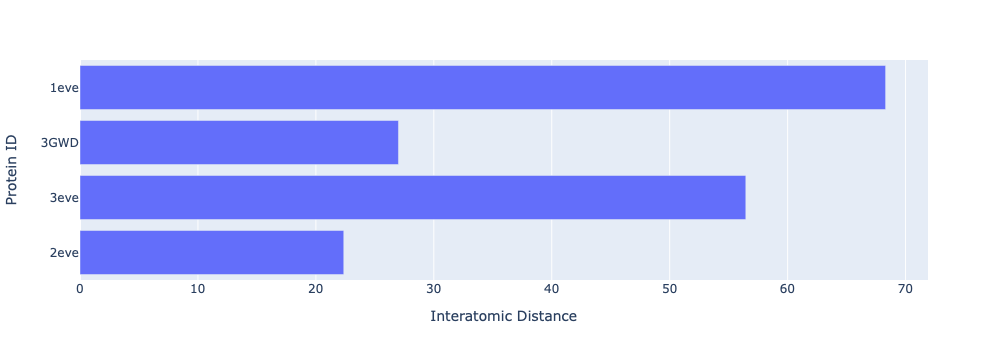

In [57]:
## Test calculate_interatomic_distances()
calculate_interatomic_distances()

## Combining All Together

### Visualization Method
This visualization method will be used for Part 2, tasks 1,2,3.

In [58]:
def generate_plot(df, by):
    
    aa  = df[by]
    frq = df["frequency"]
    prc = df["percentage"]
    
    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
    
    # Add traces
    fig.add_trace(
        go.Scatter(x=aa, y=frq, name="Frequency"),
        secondary_y=True,
    )
    
    fig.add_trace(
        go.Scatter(x=aa, y=prc, name="Percentages"),
        secondary_y=False,
    )
    
    # Add figure title
    fig.update_layout(
        title_text="Frequency & Percentages of Amino Acids"
    )
    
    # Set x-axis title
    fig.update_xaxes(title_text=by)
    
    # Set y-axes titles
    fig.update_yaxes(title_text="<b>Frequency<b>", secondary_y=True)
    fig.update_yaxes(title_text="<b>Percentages<b>", secondary_y=False)
    
    max_range = max(prc)*2
    if max_range > 100:
        max_range = 100
    fig.update_yaxes(range = [0,max_range], secondary_y=False)


    
    return fig

### Main
> Menu for Part 2, including Part 3 optional run at the end

In [59]:
def __main__():
    ## Add Files if needed.
    read_input()
    
    ## Get Dictionary of AA Frequency
    amino_acids_frq = get_data()
    
    ## Loop until User Exits
    not_exit = True
    while not_exit:
        print("Options:\n1) ALL\n2) Per category\n3) Within category\n4) Specific AA\
\nOther) Exit")
        ## Read User Choice
        choice = int(input("Choice: "))
        if choice == 1:
            ## Get Results
            df = all_combined(amino_acids_frq)
            ## Show Results DF
            print(df)
            ## Generate Plot
            fig = generate_plot(df, "amino acid")
            fig.show()
            
        elif choice == 2:
            df = by_category(amino_acids_frq)
            ## Show results
            print(df)
            ## Generate Plot
            fig = generate_plot(df, "category")
            fig.show()
        
        elif choice == 3:
            category = int(input("Enter number of category\n1. Non-polar\n\
2. Polar\n3. Negatively Charged\n4. Positively Charged\nChoice: "))
            df = all_in_category(amino_acids_frq, category)
            print (df)    
            ## Generate Plot
            fig = generate_plot(df, "amino acid")
            fig.show()
        elif choice == 4:
            df = one_aa(amino_acids_frq)
            print(df.to_string(index = False))
        else:
            not_exit = False
            print("Exiting")
    
    ## Calculate Interatomic Distances
    choice = input("Do you wish to calculate Interatomic Distances (y/n): ")
    if choice == "y":
        calculate_interatomic_distances()
    else:
        print("Done.")

## Test All Code:

Enter the number of pdb files you would like to download:  0


No files added.
-------------
Options:
1) ALL
2) Per category
3) Within category
4) Specific AA
Other) Exit


Choice:  1


   amino acid  frequency  percentage
0           G        126        8.57
1           L        126        8.57
2           V        117        7.95
3           E        107        7.27
4           A         96        6.53
5           S         90        6.12
6           T         89        6.05
7           R         87        5.91
8           D         80        5.44
9           F         76        5.17
10          P         75        5.10
11          N         70        4.76
12          K         69        4.69
13          I         65        4.42
14          Y         50        3.40
15          Q         38        2.58
16          W         35        2.38
17          H         35        2.38
18          M         24        1.63
19          C         16        1.09


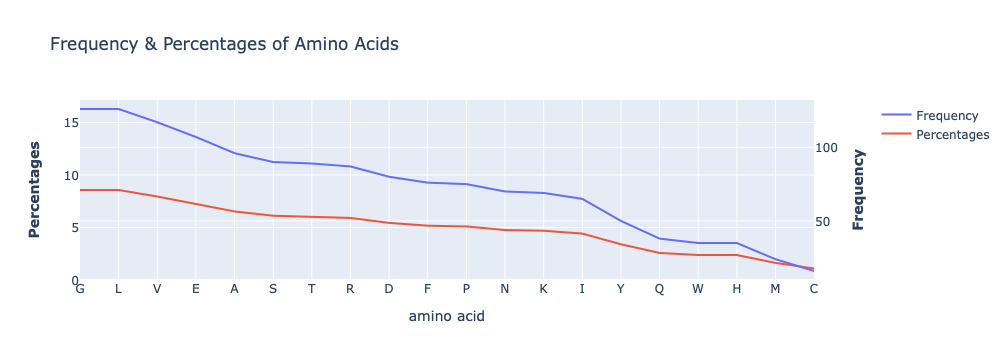

Options:
1) ALL
2) Per category
3) Within category
4) Specific AA
Other) Exit


Choice:  2


             category  frequency  percentage
0           Non-Polar        740       50.31
1               Polar        353       24.00
2  Positively Charged        191       12.98
3  Negatively Charged        187       12.71


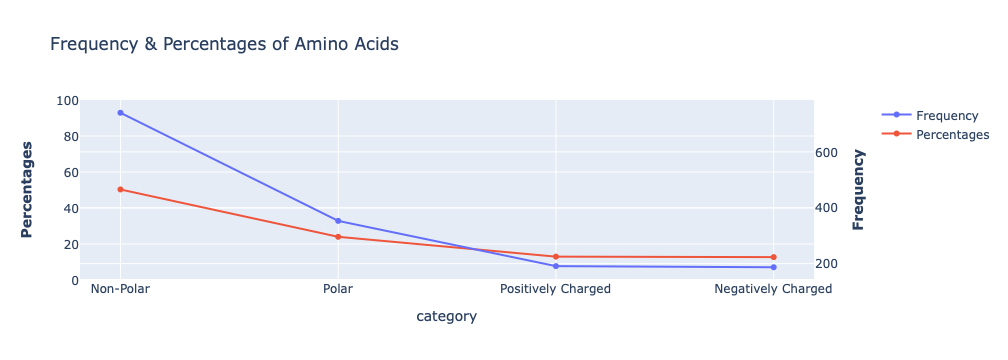

Options:
1) ALL
2) Per category
3) Within category
4) Specific AA
Other) Exit


Choice:  3
Enter number of category
1. Non-polar
2. Polar
3. Negatively Charged
4. Positively Charged
Choice:  1


  amino acid  frequency  percentage
0          L        126       17.03
1          G        126       17.03
2          V        117       15.81
3          A         96       12.97
4          F         76       10.27
5          P         75       10.14
6          I         65        8.78
7          W         35        4.73
8          M         24        3.24


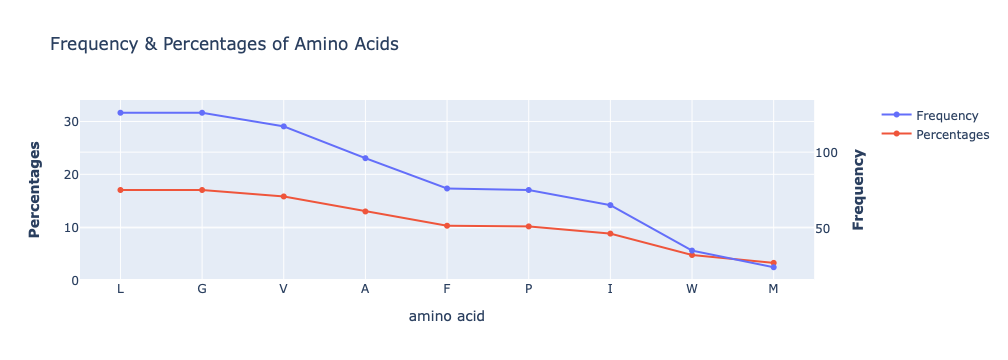

Options:
1) ALL
2) Per category
3) Within category
4) Specific AA
Other) Exit


Choice:  3
Enter number of category
1. Non-polar
2. Polar
3. Negatively Charged
4. Positively Charged
Choice:  2


  amino acid  frequency  percentage
0          S         90       25.50
1          T         89       25.21
2          N         70       19.83
3          Y         50       14.16
4          Q         38       10.76
5          C         16        4.53


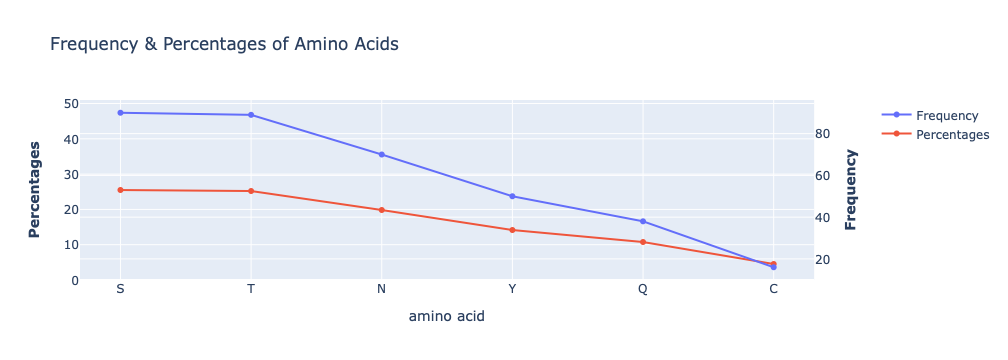

Options:
1) ALL
2) Per category
3) Within category
4) Specific AA
Other) Exit


Choice:  3
Enter number of category
1. Non-polar
2. Polar
3. Negatively Charged
4. Positively Charged
Choice:  3


  amino acid  frequency  percentage
0          E        107       57.22
1          D         80       42.78


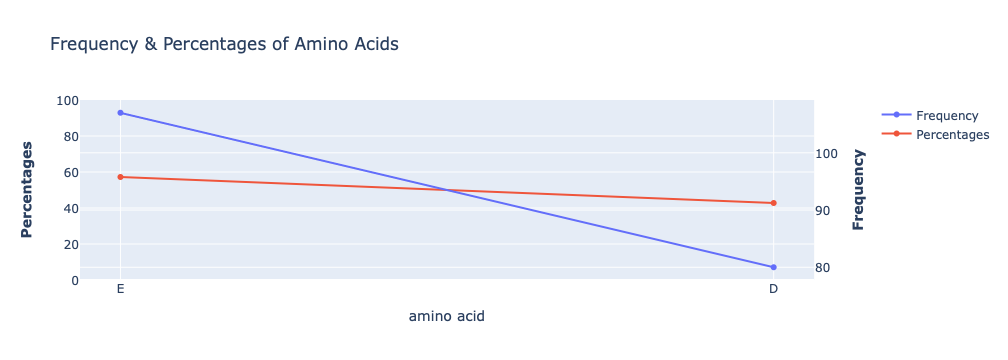

Options:
1) ALL
2) Per category
3) Within category
4) Specific AA
Other) Exit


Choice:  3
Enter number of category
1. Non-polar
2. Polar
3. Negatively Charged
4. Positively Charged
Choice:  4


  amino acid  frequency  percentage
0          R         87       45.55
1          K         69       36.13
2          H         35       18.32


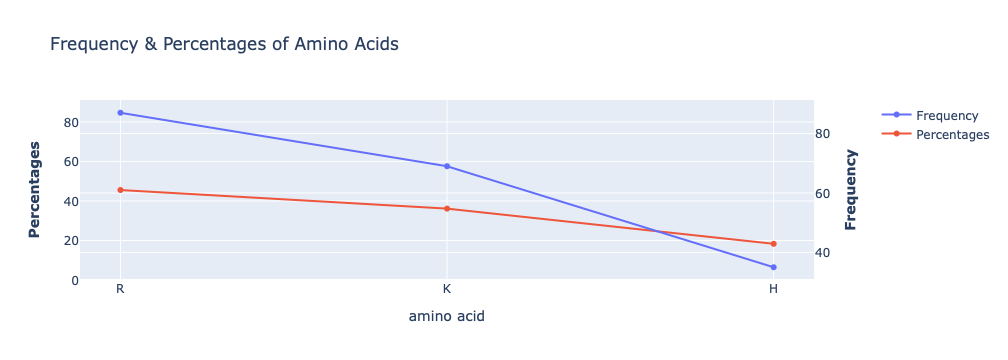

Options:
1) ALL
2) Per category
3) Within category
4) Specific AA
Other) Exit


Choice:  4


The Valid AA Codes Are:  ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']



Enter the AA One Letter Code:  A


amino acid  frequency  percentage
         A         96        6.53
Options:
1) ALL
2) Per category
3) Within category
4) Specific AA
Other) Exit


Choice:  4


The Valid AA Codes Are:  ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']



Enter the AA One Letter Code:  Z



You Entered an Invalid AA 1 Letter Code
The Valid AA Codes Are:  ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']



Enter the AA One Letter Code:  C


amino acid  frequency  percentage
         C         16        1.09
Options:
1) ALL
2) Per category
3) Within category
4) Specific AA
Other) Exit


Choice:  5


Exiting


Do you wish to calculate Interatomic Distances (y/n):  y


minimum : 22.364
maximum : 68.308
median : 41.728
mean : 43.532
std : 19.379


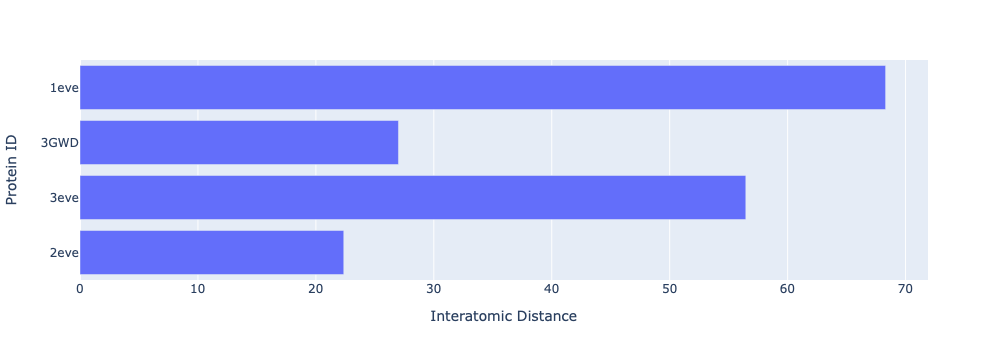

In [60]:
__main__()

---

# Take away
This semester has been one of the most interesting and difficul. Yet, this course has been the most fruitful. Through this assignment I have learnt:

1. How regex is implemented within our code. Regex in my opinion proves to be an ultimate utility in the arsenal of any well-established coder. 

2. How to use system paths and knowledge of the terminal within the scripting assignment (surface knowledge to what was covered).

3. How to implement dictionaries in somewhat complex ways.

4. How to plot data and use various python libraries to visualize it.

5. How to webscape data. With PDB being the model in this assignment, it still served for a great example in how one could combine all of the above learning outcomes (Python, Regex, Plotting Libraries, to generate powerful tools for bioinformaticians and to a certain extent businesses in general. 

Final notes: thank you for leaving a positive impact in my learning experience and passion towards my major. I was fascinated with the simplicity that builds up to create essential and pivotal tools regardless of field. 

Student: Osama Shamout <br> LAU ID: 201906271

---